# GBT  CoDR experiments

We implement some of the classes listed in V1.0 of the CoDR.   

* these are toy classes
* very minimal error checking
* an assumed organization of PS


This should eventually reproduce Example 1 (position switching) from the GBTIDL manual. The datafile **ngc5291.fits** you need is [here](http://safe.nrao.edu/wiki/pub/GB/Data/GBTIDLExampleAndSampleData/ngc5291.fits) or locally on **/n/chara/teuben/GBT**.  

## Example

We start off with a session as a GBT user might see this:

        ps = GBTLoadPS('a.fits')        # load the SDFITS file
        ps.summary()                    # overview times, sources, scans etc.
        ps.finalspectrum()              # calibrate and time/pol average
        ps.plot()                       # review the final plot
        ps.save('a1.fits')              # save the spectrum (also SDFITS format)
        
This is an example of a well behave spectrum. No masking needed, no baseline fitting, just simple timeaveraging.

In [1]:
%matplotlib inline

from astropy.io import fits
from astropy import units as u
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from specutils import Spectrum1D, SpectrumList

from astropy.io import ascii
from astropy.nddata import StdDevUncertainty
from astropy.table import Table
from astropy.units import Unit
from astropy.wcs import WCS
from astropy.convolution import convolve, Box1DKernel

from specutils.io import get_loaders_by_extension
from specutils.io.registers import data_loader
from specutils import Spectrum1D

# Spectrum

The class that contains one spectrum

In [2]:
class Spectrum(object):
    """
    contain a basic spectrum (cg. Spectrum1D in specutils)
    not used by users
    """
    def __init__(self, bintable_row):
        self.data = bintable_row['DATA']
        self.meta = bintable_row
        self.gbt  = {}
        #
        nchan = len(self.data)        
        crval1 = bintable_row['CRVAL1']
        cdelt1 = bintable_row['CDELT1']
        crpix1 = bintable_row['CRPIX1']
        freq0  = bintable_row['RESTFREQ']
        freq = (crval1 + (np.arange(1,nchan+1) - crpix1) * cdelt1)/1e9
        self.xvals = freq
        
    def stats(self, chans=None, label=""):
        """
        show Mean,RMS,Min,Max
        """
        if chans==None:
            c0 = 0
            c1 = len(self.data)
        else:
            c0 = chans[0]
            c1 = chans[1]
        mean = self.data[c0:c1].mean()
        rms  = self.data[c0:c1].std()
        dmin = self.data[c0:c1].min()
        dmax = self.data[c0:c1].max()
        ndat = c1-c0
        print("%s  %s %s %s %s %d" %  (label,repr(mean),repr(rms),repr(dmin),repr(dmax),ndat))
    
    def plot(self):
        plt.plot(self.xvals, self.data)
        
        

# SDFITSLoad

This is the class that loads an SDFITS file. Normally not called by users, but by classes such as GBTLoadPS()



In [3]:
class SDFITSLoad(object):
    """
    container for a bintable from a selected HDU
    normally not used by users
    """
    def __init__(self, filename, hdu=1):
        """
        """
        print("==SDFITSLoad %s" % filename)
        self.filename = filename
        self.bintable = None
        self.hdu = fits.open(filename)
        self.header = self.hdu[0].header
        self.load(hdu)
    def load(self, hdu=1):
        """
        for given hdu make this bintable available
        """
        self.bintable = self.hdu[hdu]
        self.header2  = self.bintable.header
        self.data2    = self.bintable.data
        src = np.unique(self.data2[:]['OBJECT'])
        scan = np.unique(self.data2[:]['SCAN'])
        ncols = self.header2['NAXIS1']
        nrows = self.header2['NAXIS2']
        #
        print("File:     %s   HDU %d" % (self.filename, hdu))
        print("BINTABLE: %d rows x %d cols" % (nrows,ncols))
        print("Sources: ",src)
        print("Scans:   ",scan)
    def __len__(self):
        return self.header2['NAXIS2']
        
        
s = SDFITSLoad('ngc5291.fits')

==SDFITSLoad ngc5291.fits
File:     ngc5291.fits   HDU 1
BINTABLE: 352 rows x 131458 cols
Sources:  ['NGC5291']
Scans:    [51 52 53 54 55 56 57 58]


# GBTLoad

This is the base class from which we derive all GBTLoad* subclasses that can load and calibrate spectra. It can also be used to load all the spectra, but there is no structure defined, e.g. to check and guide calibration.

In [4]:
class GBTLoad(object):
    def __init__(self, filename):
        """
        Holds a raw "unstructured" series of scans, normally not used by users
        """
        def ushow(name):
            uname = np.unique(self.s.data2[:][name])
            print('uniq',name,uname)
            return uname          
        print("==GBTLoad %s" % filename)
        self.filename = filename
        self.s = SDFITSLoad(filename)
        ushow('OBJECT')
        ushow('SCAN')
        ushow('SAMPLER')
        ushow('SIG')
        ushow('CAL')
        ushow('PROCSEQN')
        ushow('PROCSIZE')
        ushow('OBSMODE')               
        
        self.nrows = self.s.header2['NAXIS2']
        self.sp = np.empty(self.nrows, dtype=Spectrum)
        for i in range(self.nrows):
            self.sp[i] = Spectrum(self.s.data2[i])
            self.sp[i].gbt['row'] = i
            
    def __len__(self):
        return self.nrows
    def __getitem__(self, index):
        return self.sp[index]
    def __repr__(self):
        return self.filename
    def stats(self, chans=None):
        """
        show Mean,RMS,Min,Max
        """
        for i in range(self.nrows):
            self.sp[i].stats(chans,"%04d" % i)
    def debug(self, vars):
        """
        show some meta data variables
        """
        for i in range(self.nrows):
            out = ""
            for v in vars:
                out = out + repr(self.s.data2[i][v]) + " "
            print(out)

# PS example      
ex1 = GBTLoad('ngc5291.fits')

==GBTLoad ngc5291.fits
==SDFITSLoad ngc5291.fits
File:     ngc5291.fits   HDU 1
BINTABLE: 352 rows x 131458 cols
Sources:  ['NGC5291']
Scans:    [51 52 53 54 55 56 57 58]
uniq OBJECT ['NGC5291']
uniq SCAN [51 52 53 54 55 56 57 58]
uniq SAMPLER ['A13' 'A9']
uniq SIG ['T']
uniq CAL ['F' 'T']
uniq PROCSEQN [1 2]
uniq PROCSIZE [2]
uniq OBSMODE ['OnOff:PSWITCHOFF:TPWCAL' 'OnOff:PSWITCHON:TPWCAL']


In [5]:
#   FS example 
#ex2 = GBTLoad('W3OH.fits')

In [6]:
# NOD example 
#ex3 = GBTLoad('IC1481.fits')

In [7]:
# EDGE example 
#ex4 = GBTLoad('AGBT15B_287_35.raw.vegas.A.fits')

In [8]:
# ARGUS example
#ex5 = GBTLoad('AGBT17B_151_01.raw.vegas.A.fits')

In [9]:
#ex1.stats([3000,4000])
#ex1.debug(['DATE-OBS','CAL','SAMPLER','PROCSEQN'])

# PSScan

This class holds one PS scan, which consists of an "On" and "Off" scan.

In [10]:
class PSScan(object):
    """
    Holds a PS scan - never used by users
    GBTLoadPS will hold one or more of such scans
    """
    #
    def __init__(self, sdfits, scan_on, scan_off):
        """
        """
        self.sdfits = sdfits
        self.status = 0
        #                           # ex1:
        self.nint = 0               # 11
        self.npol = 0               #  2
        self.on = None              # 44
        self.off = None             # 44
        self.calibrated = None      # 22
        self.timeaveraged = None    #  2
        self.polaveraged = None     #  1
        #
        self.nrows = len(scan_on)
        self.on = np.empty(self.nrows, dtype=Spectrum)
        self.off = np.empty(self.nrows, dtype=Spectrum)
        for (i,j,k) in zip(range(len(scan_on)),scan_on, scan_off):
            self.on[i] = Spectrum(sdfits.data2[j])
            self.off[i] = Spectrum(sdfits.data2[k])
            # remember the original row
            self.on[i].gbt['row'] = j
            self.off[i].gbt['row'] = k
        self.npol = 2
        self.nint = self.nrows // 4
    def debug(self):
        """
        no debug
        """
        print("WIP")
    def calibrate(self):
        """
        special PS calibration
        """
        self.status = 1
        npolint = self.npol * self.nint
        self.calibrated = np.empty(npolint, dtype=Spectrum)
        for i in range(npolint):
            tsys = 2.4   # figure this out from dcmeantsys
            tcal = 2.4
            calon = self.on[2*i].data
            caloff = self.off[2*i].data
            kr = self.on[2*i].gbt['row']      #  BAD 'row'
            self.calibrated[i] = Spectrum(self.sdfits.data2[kr])
            self.calibrated[i].data = tcal * caloff / (calon-caloff) + tcal/2.0
            self.calibrated[i].gbt['row'] = kr
            # fix the meta data ; most of it is ok
    def timeaverage(self):
        """
        time averaging
        """
        self.status = 2
        self.timeaveraged = np.empty(self.npol, dtype=Spectrum)
        for i in range(self.npol):
            for j in range(self.nint):
                k = i*self.nint + j
                if j == 0:
                    data = self.calibrated[k].data
                else:
                    data = data + self.calibrated[k].data
            kr = self.calibrated[k].gbt['row']   
            self.timeaveraged[i] = Spectrum(self.sdfits.data2[kr])
            self.timeaveraged[i].data = data / self.nint
            self.timeaveraged[i].gbt['row'] = kr
            # fix the meta data; most of it is ok
    def polaverage(self):
        """
        polarization averaged ; needs to be stokes smart 
        """
        self.status = 3
        self.polaveraged = np.empty(1, dtype=Spectrum)
        for i in range(self.npol):
            if i==0:
                data = self.timeaveraged[i].data
            else:
                data = data + self.timeaveraged[i].data
        kr = self.timeaveraged[0].gbt['row']
        self.polaveraged[0] = Spectrum(self.sdfits.data2[kr])
        self.polaveraged[0].data = data / self.npol
        self.polaveraged[0].gbt['row'] = kr
        # fix the meta data
        
        

# GBTLoadPS

This is the class that loads and calibrates Position Switched (PS) data

In [11]:
def uniq(seq):
    """ from http://stackoverflow.com/questions/480214/how-do-you-remove-duplicates-from-a-list-in-python-whilst-preserving-order """
    seen = set()
    seen_add = seen.add
    return [ x for x in seq if x not in seen and not seen_add(x)]


In [12]:
class GBTLoadPS(GBTLoad):
    """
    
    """
    def __init__(self, filename):
        """
        Load SDFITS into a PS structure
        - should also allow SDFITSLoad() list
        - should also allow filename list
        - all assumed hdu=1
        """
        def ushow(name, show=False):
            uname = np.unique(self.sdfits.data2[:][name])
            if show: print('uniq',name,uname)
            return uname
        def wh(name,val):
            print('no')
                              
        self.filename = filename
        self.sdfits = SDFITSLoad(filename)
        self.scan = {}
        self.scanaveraged = None
        #
        self.status = 0    # 0 = uncalibrated
        #
        d = self.sdfits.data2
        self.object = ushow('OBJECT')
        self.scans = ushow('SCAN')
        pols = ushow('SAMPLER')
        sigs = ushow('SIG')
        cals = ushow('CAL')
        proc = ushow('PROCSEQN')
        ushow('PROCSIZE')
        ushow('OBSMODE',True)
        dates = ushow('DATE-OBS')
        self.date0 = dates[0]
        self.date1 = dates[-1]
        # hardcoded
        s1 = [51, 53, 55, 57]
        s2 = [52, 54, 56, 58]
        idx = np.arange(len(self.sdfits))
        for (i1,i2) in zip(s1,s2):
            scan_on = idx[d['SCAN'] == i1]
            scan_off = idx[d['SCAN'] == i2]
            print(i1,'on',scan_on[0],'...',scan_on[-1])
            print(i2,'off',scan_off[0],'...',scan_off[-1])
            self.scan[i1] = PSScan(self.sdfits, scan_on, scan_off)
        
    def summary(self):
        print("GBTLoadPS %s" % self.filename)
        print("Sources:",self.object)
        print("Scans:",self.scans)
        print("Dates:",self.date0,self.date1)
    def stats(self, range=None):
        print('WIP')
    def calibrate(self):
        """
        calibrate
        """
        self.status = 1 
        for scan in self.scan.keys():
            print("Calibrating",scan)
            self.scan[scan].calibrate()
            
    def timeaverage(self):
        """
        average in time for all scans
        """
        self.status = 2
        for scan in self.scan.keys():
            print("Timeaver",scan)
            self.scan[scan].timeaverage()
            
    def polaverage(self):
        """
        average in time for all scans
        """
        self.status = 3
        for scan in self.scan.keys():
            print("Polaver",scan)
            self.scan[scan].polaverage()
            
    def scanaverage(self):
        """
        averaging over scans
        """
        self.status = 4
        nscan = len(self.scan.keys())
        print("Scanaverage over %d scans" % nscan)
        self.scanaveraged = np.empty(1, dtype=Spectrum)
        for (i,scan) in zip(range(nscan),self.scan.keys()):
            kr = self.scan[scan].polaveraged[0].gbt['row']
            print('Scan %d Row %d' % (scan,kr))
            if i==0:
                data = self.scan[scan].polaveraged[0].data
            else:
                data = data + self.scan[scan].polaveraged[0].data
        data = data / nscan
        self.scanaveraged[0] = Spectrum(self.sdfits.data2[kr])
        self.scanaveraged[0].data = data / nscan
        self.scanaveraged[0].gbt['row'] = kr          

p = GBTLoadPS('ngc5291.fits')

==SDFITSLoad ngc5291.fits
File:     ngc5291.fits   HDU 1
BINTABLE: 352 rows x 131458 cols
Sources:  ['NGC5291']
Scans:    [51 52 53 54 55 56 57 58]
uniq OBSMODE ['OnOff:PSWITCHOFF:TPWCAL' 'OnOff:PSWITCHON:TPWCAL']
51 on 0 ... 43
52 off 44 ... 87
53 on 88 ... 131
54 off 132 ... 175
55 on 176 ... 219
56 off 220 ... 263
57 on 264 ... 307
58 off 308 ... 351


In [13]:
p.calibrate()

Calibrating 51
Calibrating 53
Calibrating 55
Calibrating 57


/home/teuben/GBT/gbtoy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


In [14]:
p.timeaverage()

Timeaver 51
Timeaver 53
Timeaver 55
Timeaver 57


In [15]:
p.polaverage()

Polaver 51
Polaver 53
Polaver 55
Polaver 57


In [16]:
p.scanaverage()

Scanaverage over 4 scans
Scan 51 Row 20
Scan 53 Row 108
Scan 55 Row 196
Scan 57 Row 284


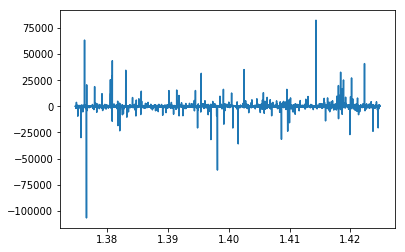

In [17]:
p.scanaveraged[0].plot()